We do feature selection to:
- reduce the computational cost of the model
- in some cases, improve the performance of the model


The method of the measuring depends on the input and output of the variable - categorical or numerical.

What I am doing is supervised feature selection, which means that I am using the target variable to select the features.



In [28]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import pandas as pd
from make_predictions import make_predictions
from settings import PROCESSED_DATA_DIR, INTERIM_DATA_DIR

matches_df = pd.read_csv(Path(PROCESSED_DATA_DIR, 'bundesliga_matches.csv'))

In [29]:
matches_df.head()

,gf_rolling_avg,ga_rolling_avg,xg_rolling_avg,xga_rolling_avg,poss_rolling_avg,attendance_rolling_avg,shooting_standard_sh_rolling_avg,shooting_standard_sot_rolling_avg,shooting_standard_sot%_rolling_avg,shooting_standard_g/sh_rolling_avg,...,opponent_code,venue_code,hour,day_code,month_code,target,date,team,opponent,venue
0,0.666667,0.666667,0.700000,1.366667,49.000000,4086.666667,9.333333,3.333333,35.433333,0.073333,...,3,1,18,5,10,0,2020-10-17,Arminia,Bayern Munich,Home
1,0.666667,1.666667,0.900000,1.633333,47.666667,NaN,9.000000,3.666667,39.500000,0.076667,...,26,0,15,6,10,0,2020-10-25,Arminia,Wolfsburg,Away
2,0.666667,2.333333,1.000000,1.900000,49.333333,NaN,9.666667,3.333333,33.666667,0.066667,...,6,1,15,5,10,0,2020-10-31,Arminia,Dortmund,Home
3,0.666667,2.666667,0.733333,2.566667,37.000000,NaN,8.333333,2.666667,32.200000,0.066667,...,24,0,15,5,11,0,2020-11-07,Arminia,Union Berlin,Away
4,0.333333,3.000000,0.366667,2.200000,42.000000,NaN,6.666667,1.333333,22.600000,0.036667,...,2,1,15,5,11,0,2020-11-21,Arminia,Bayer Leverkusen,Home


In [30]:
temp_df = matches_df.copy()
# Select numeric only.
temp_df = temp_df.select_dtypes(['number'])
cor = temp_df.corr()
cor_target = abs(cor['target'])
# Columns that have any positive correlation with the target.
relevant_features = cor_target[cor_target>0.2]
relevant_features

passing_total_cmp_rolling_avg                0.215884
passing_total_att_rolling_avg                0.216540
passing_total_totdist_rolling_avg            0.201013
passing_short_cmp_rolling_avg                0.214122
passing_short_att_rolling_avg                0.214758
passing_1/3_rolling_avg                      0.203619
passing_prgp_rolling_avg                     0.208952
passing_types_pass_types_live_rolling_avg    0.217866
possession_touches_touches_rolling_avg       0.212700
possession_touches_mid_3rd_rolling_avg       0.201311
possession_touches_att_3rd_rolling_avg       0.206332
possession_touches_live_rolling_avg          0.212673
possession_carries_carries_rolling_avg       0.200730
possession_carries_totdist_rolling_avg       0.200931
possession_receiving_rec_rolling_avg         0.215906
possession_receiving_prgr_rolling_avg        0.209094
target                                       1.000000
Name: target, dtype: float64

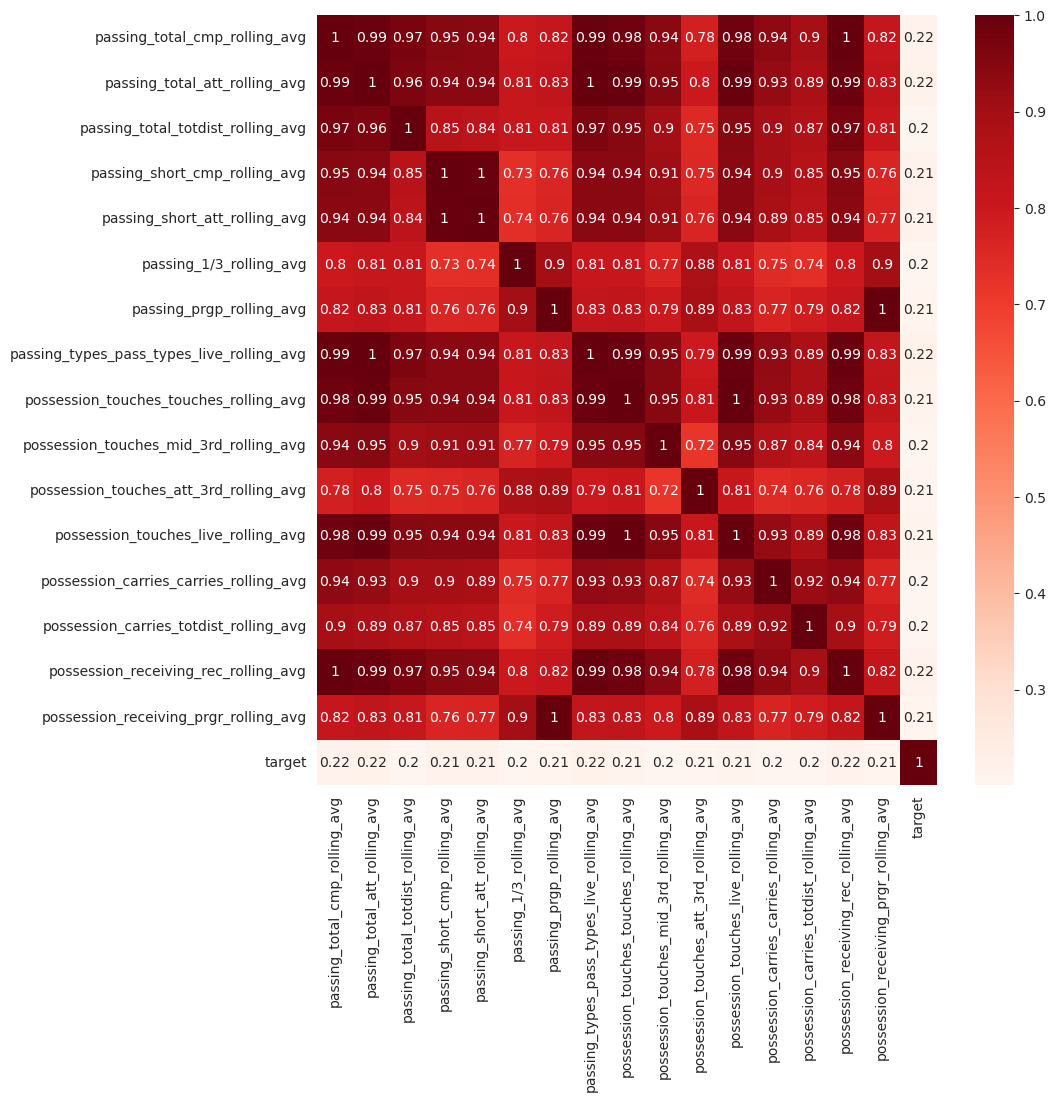

In [31]:
# get the relevant features and see correlation between them
cor = matches_df[relevant_features.index].corr()
# visualize that cor
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

[How to choose feature selection method](https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Numerical input, categorical output
- ANOVA correlation coefficient
- Kendall's rank correlation



The more columns I use, the better the precision???

In [32]:
relevant_features = cor_target[cor_target>0.2]
print(f'Using {len(relevant_features)} features')
print(f'Total cols {matches_df.shape[1]}')
relevant_features = relevant_features.drop('target')
make_predictions(matches_df, relevant_features.index)

Using 17 features
Total cols 157
Train: 3437 matches (90.71%)
Test: 352 matches (9.29%)
Precision: 49.41%


0.49411764705882355

In [33]:
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.impute import SimpleImputer
from reduce_memory_usage import reduce_memory_usage

# Copy and preprocess the DataFrame
temp_df = matches_df.copy()
temp_df = reduce_memory_usage(temp_df)
temp_df = temp_df.select_dtypes(['number'])
x = temp_df.drop('target', axis=1)
y = temp_df['target']
x = x.select_dtypes(exclude=['object'])

# Handle NaN values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)

best_percentile = 0
best_precision = 0
best_predictors = []

for percentile in range(5, 101, 5):
    selector = SelectPercentile(f_classif, percentile=percentile)

    # Fit and transform the imputed data
    x_new = selector.fit_transform(x_imputed, y)

    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)

    # Get selected column names
    selected_columns = x.columns[selected_indices]

    # Check if matches_df has a column with rolling avg       at '2023-11-10' I GET 100%%%
    precision = make_predictions(matches_df, selected_columns, cutoff_date='2023-10-10')

    print(f'Precision: {precision} with percentile: {percentile}')

    if precision > best_precision:
        best_precision = precision
        best_percentile = percentile
        best_predictors = selected_columns

print('----------------------------------')
print(f'Best precision: {best_precision} with percentile: {best_percentile}')
print(f'Len of predictors: {len(best_predictors)}')
print(f'Best predictors: {best_predictors}')

Memory usage of dataframe is 4.538646697998047 MB
Memory usage of dataframe after reduction 1.1289539337158203 MB
Reduced by 75.12575864929538 % 
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 56.25%
Precision: 0.5625 with percentile: 5
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 68.42%
Precision: 0.6842105263157895 with percentile: 10
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 50.00%
Precision: 0.5 with percentile: 15
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 62.50%
Precision: 0.625 with percentile: 20
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 53.85%
Precision: 0.5384615384615384 with percentile: 25
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 43.75%
Precision: 0.4375 with percentile: 30
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 55.00%
Precision: 0.55 with percentile: 35
Train: 3717 matches (98.10%)
Test: 72 matches (1.90%)
Precision: 60